In [ ]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LogisticRegression,
    Trainer
)

# User-defined functions
from utils.preprocess import clusters

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [92]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 20
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [93]:
X, y = clusters(SIZE, std0 = 1.3, std1 = 1.6)

In [94]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-4.4869, -3.2518],
        [-2.6995, -2.1331],
        [-0.8858, -1.6624],
        [-1.6588, -4.5647],
        [-2.5336, -1.0124],
        [-1.6680, -3.0128],
        [-1.5616, -4.3118],
        [-2.6431, -4.0322],
        [-3.5987, -2.7166],
        [-3.0213, -2.2345],
        [-5.4842, -1.2088],
        [-3.0118, -2.4886],
        [-1.9521, -2.6328],
        [-5.5931, -3.1587],
        [-3.6862, -2.1964],
        [-4.1431, -2.0111],
        [-1.8851, -4.9222],
        [-3.9070, -5.0606],
        [-1.1803, -3.9101],
        [-2.5425, -3.4568],
        [-2.3023, -3.8326],
        [-0.0818, -1.2413],
        [-3.5438, -3.6510],
        [-2.1320, -5.0583],
        [-3.8799, -3.9897],
        [-2.6738, -2.6703],
        [-5.2431, -5.2010],
        [-2.5177, -2.0400],
        [-3.0164, -1.5766],
        [-4.9032, -3.1473],
        [-4.2449, -2.1451],
        [-3.9733, -4.4854],
        [-1.6540, -2.3423],
        [-3.8695, -4.0591],
        [-4.8471, -3.2177],
       

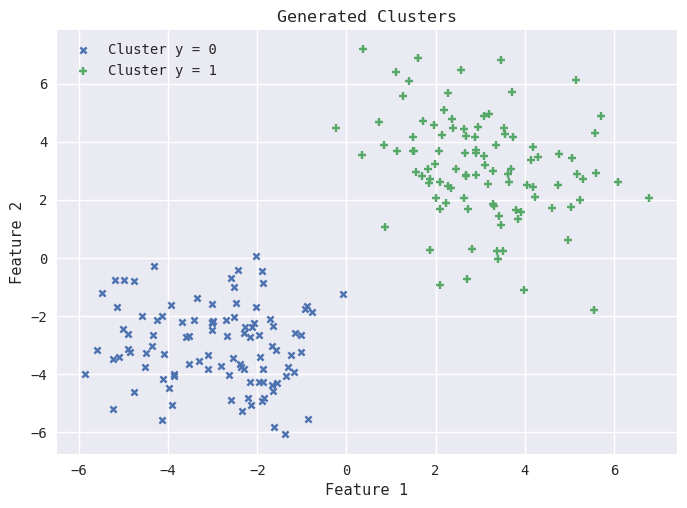

In [95]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Clusters')
plt.show()

In [96]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [97]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-4.4869, -3.2518],
         [-2.6995, -2.1331],
         [-0.8858, -1.6624],
         [-1.6588, -4.5647],
         [-2.5336, -1.0124],
         [-1.6680, -3.0128],
         [-1.5616, -4.3118],
         [-2.6431, -4.0322],
         [-3.5987, -2.7166],
         [-3.0213, -2.2345],
         [-5.4842, -1.2088],
         [-3.0118, -2.4886],
         [-1.9521, -2.6328],
         [-5.5931, -3.1587],
         [-3.6862, -2.1964],
         [-4.1431, -2.0111],
         [-1.8851, -4.9222],
         [-3.9070, -5.0606],
         [-1.1803, -3.9101],
         [-2.5425, -3.4568],
         [-2.3023, -3.8326],
         [-0.0818, -1.2413],
         [-3.5438, -3.6510],
         [-2.1320, -5.0583],
         [-3.8799, -3.9897],
         [-2.6738, -2.6703],
         [-5.2431, -5.2010],
         [-2.5177, -2.0400],
         [-3.0164, -1.5766],
         [-4.9032, -3.1473],
         [-4.2449, -2.1451],
         [-3.9733, -4.4854],
         [-1.6540, -2.3423],
         [-3.8695, -4.0591],
         [-4.8

In [98]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)

In [99]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.BCELoss(reduction='mean'),        # Binary Cross-entropy Loss (For classification)
    device=DEVICE
)

In [100]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([0.0742, 0.1602], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4855], device='cuda:0')
	Epoch 1 | Weights: tensor([0.1823, 0.2624], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4678], device='cuda:0')
	Epoch 1 | Weights: tensor([0.2373, 0.3178], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4674], device='cuda:0')
	Epoch 1 | Weights: tensor([0.2908, 0.3639], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4601], device='cuda:0')
	Epoch 1 | Weights: tensor([0.3350, 0.4022], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4502], device='cuda:0')
Epoch 1/20 | Loss: 0.3767
	| Validation Loss: 0.1520

	Epoch 2 | Weights: tensor([0.3665, 0.4271], device='cuda:0')
	Epoch 2 | Bias: tensor([0.4490], device='cuda:0')
	Epoch 2 | Weights: tensor([0.3946, 0.4541], device='cuda:0')
	Epoch 2 | Bias: tensor([0.4438], device='cuda:0')
	Epoch 2 | Weights: tensor([0.4228, 0.4772], device='cuda:0')
	Epoch 2 | Bias: tensor([0.4378], device='cuda:0')
	Epoch 2 | Weights: tensor([0.4472, 0.4974

In [101]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 0.37666845619678496, 1: 0.10801999419927596, 2: 0.06968687027692795, 3: 0.05277498960494995, 4: 0.04303326830267906, 5: 0.03665733188390732, 6: 0.03209274634718895, 7: 0.02867105379700661, 8: 0.025998324528336524, 9: 0.02382812462747097, 10: 0.022015411779284476, 11: 0.020509274676442146, 12: 0.01921759285032749, 13: 0.01809846069663763, 14: 0.01710791438817978, 15: 0.016246567107737066, 16: 0.015468647330999374, 17: 0.014774429704993963, 18: 0.014165876060724258, 19: 0.013576631247997285}

Validation Loss:
{0: 0.15195821225643158, 1: 0.08327576145529747, 2: 0.06575243547558784, 3: 0.05122485011816025, 4: 0.04206716362386942, 5: 0.062047041952610016, 6: 0.03262469079345465, 7: 0.026469634845852852, 8: 0.025705164298415184, 9: 0.03383435122668743, 10: 0.041714915074408054, 11: 0.022685996256768703, 12: 0.022491639479994774, 13: 0.027939599938690662, 14: 0.02908121608197689, 15: 0.027598027139902115, 16: 0.023282035253942013, 17: 0.015730055747553706, 18: 0.01814953703433

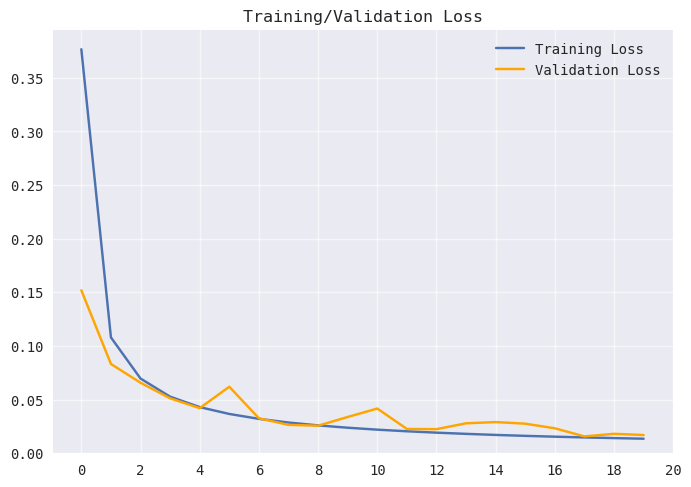

In [102]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-0);
plt.xticks(np.linspace(0, 20, 11));
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [103]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.w), "Bias: {}".format(Model.b), sep="\n")

Predicted Model Parameters:
Weights: Parameter containing:
tensor([0.9980, 0.8889], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([0.3609], device='cuda:0', requires_grad=True)


In [104]:
T = torch.linspace(X.min(), X.max(), SIZE, dtype=DTYPE, device=DEVICE).reshape(SIZE, 1)
T = torch.cat([T, T], dim=1)

slope = -Model.w[0] / Model.w[1]
interc = -Model.b / Model.w[1]
boundary = slope * T + interc

print("Tensor T to plot the boundary:", T, sep='\n')

Tensor T to plot the boundary:
tensor([[-6.0714, -6.0714],
        [-5.9377, -5.9377],
        [-5.8039, -5.8039],
        [-5.6701, -5.6701],
        [-5.5363, -5.5363],
        [-5.4026, -5.4026],
        [-5.2688, -5.2688],
        [-5.1350, -5.1350],
        [-5.0012, -5.0012],
        [-4.8674, -4.8674],
        [-4.7337, -4.7337],
        [-4.5999, -4.5999],
        [-4.4661, -4.4661],
        [-4.3323, -4.3323],
        [-4.1985, -4.1985],
        [-4.0648, -4.0648],
        [-3.9310, -3.9310],
        [-3.7972, -3.7972],
        [-3.6634, -3.6634],
        [-3.5296, -3.5296],
        [-3.3959, -3.3959],
        [-3.2621, -3.2621],
        [-3.1283, -3.1283],
        [-2.9945, -2.9945],
        [-2.8608, -2.8608],
        [-2.7270, -2.7270],
        [-2.5932, -2.5932],
        [-2.4594, -2.4594],
        [-2.3256, -2.3256],
        [-2.1919, -2.1919],
        [-2.0581, -2.0581],
        [-1.9243, -1.9243],
        [-1.7905, -1.7905],
        [-1.6567, -1.6567],
        [-1.5230,

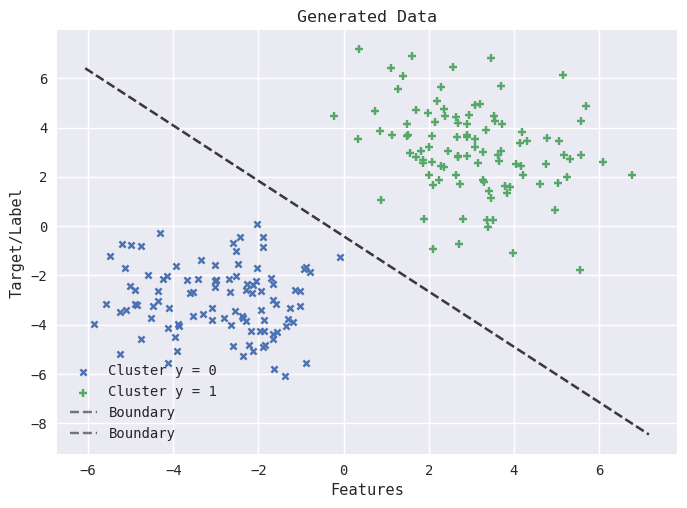

In [105]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
# Decision Boundary
plt.plot(
    T[:, 1].detach().cpu(),
    boundary.detach().cpu(),
    alpha=.5,
    color='black',
    linestyle='--',
    label="Boundary"
);

plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();